# **Experiment-8: Demonstrate the working of the decision tree based ID3 algorithm. Use an appropriate data set for building the decision tree and apply this knowledge to classify a new sample.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import log2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

# Load TSA Claims Dataset
print("\nLoading TSA Claims Database...")
try:
    df = pd.read_csv('TSA Claims Database 2015-2022.csv')
    print("Dataset loaded successfully from 'TSA Claims Database 2015-2022.csv'")
except:
    try:
        df = pd.read_csv('tsa_claims.csv')
        print("Dataset loaded successfully from 'tsa_claims.csv'")
    except:
        try:
            df = pd.read_csv('TSAClaims2015_2022.csv')
            print("Dataset loaded successfully from 'TSAClaims2015_2022.csv'")
        except:
            print("Please download the dataset from Kaggle:")
            print("https://www.kaggle.com/datasets/terminal-security-agency/tsa-claims-database/data")
            print("and ensure the CSV file is in your working directory")

print(f"\nDataset Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Columns:")
print(df.columns.tolist())

All libraries imported successfully!

Loading TSA Claims Database...
Dataset loaded successfully from 'tsa_claims.csv'

Dataset Shape: (204267, 13)

First 5 rows:
    Claim Number Date Received    Incident Date Airport Code  \
0       0909802M      4-Jan-02  12/12/2002 0:00          EWR   
1       0202417M      2-Feb-02   1/16/2004 0:00          SEA   
2       0202445M      4-Feb-02  11/26/2003 0:00          STL   
3       0909816M      7-Feb-02    1/6/2003 0:00          MIA   
4  2005032379513     18-Feb-02    2/5/2005 0:00          MCO   

                      Airport Name          Airline Name       Claim Type  \
0     Newark International Airport  Continental Airlines  Property Damage   
1     Seattle-Tacoma International                   NaN  Property Damage   
2  Lambert St. Louis International     American Airlines  Property Damage   
3      Miami International Airport     American Airlines  Property Damage   
4    Orlando International Airport          Delta (Song)  Property 

In [ ]:
# Explore the dataset structure
print("Dataset Overview:")
print("=" * 50)

# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Identify categorical columns suitable for ID3
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"\nCategorical Columns ({len(categorical_cols)}):")
print(categorical_cols.tolist())

# Display unique values for key categorical columns
print("\nUnique values in key columns:")
for col in categorical_cols[:6]:
    print(f"{col}: {df[col].nunique()} unique values")
    if df[col].nunique() <= 10:
        print(f"   Values: {df[col].unique()}")

Dataset Overview:
Missing Values:
Claim Number         0
Date Received      263
Incident Date     2183
Airport Code      8524
Airport Name      8524
Airline Name     34374
Claim Type        7913
Claim Site         740
Item              3966
Claim Amount      4043
Status               5
Close Amount     68952
Disposition      72908
dtype: int64

Categorical Columns (13):
['Claim Number', 'Date Received', 'Incident Date', 'Airport Code', 'Airport Name', 'Airline Name', 'Claim Type', 'Claim Site', 'Item', 'Claim Amount', 'Status', 'Close Amount', 'Disposition']

Unique values in key columns:
Claim Number: 204258 unique values
Date Received: 4007 unique values
Incident Date: 26807 unique values
Airport Code: 465 unique values
Airport Name: 485 unique values
Airline Name: 318 unique values


In [ ]:
# Select appropriate features and target for ID3
print("Selecting features for ID3 Decision Tree...")

# Common column names in TSA dataset
possible_status_cols = ['Claim_Type', 'Status', 'Disposition', 'Close_Amount', 'Claim_Amount']
available_cols = [col for col in possible_status_cols if col in df.columns]

print(f"Available relevant columns: {available_cols}")

# Create a processed dataset
if len(available_cols) >= 3:
    target_col = available_cols[0]
    feature_cols = available_cols[1:3]

    # Add more categorical features if available
    additional_cats = [col for col in categorical_cols if col not in available_cols and df[col].nunique() <= 10]
    if len(additional_cats) >= 2:
        feature_cols.extend(additional_cats[:2])

    df_subset = df[feature_cols + [target_col]].copy()

else:
    # If expected columns not found, use first suitable categorical columns
    suitable_cols = []
    for col in categorical_cols:
        if 2 <= df[col].nunique() <= 10:
            suitable_cols.append(col)
        if len(suitable_cols) >= 4:
            break

    if len(suitable_cols) >= 3:
        target_col = suitable_cols[0]
        feature_cols = suitable_cols[1:4]
        df_subset = df[feature_cols + [target_col]].copy()
    else:
        # Create meaningful synthetic data based on TSA context
        print("Creating TSA-themed synthetic data for demonstration...")
        np.random.seed(42)

        n_samples = 500
        claim_type = np.random.choice(['Property Damage', 'Personal Injury', 'Lost Luggage', 'Theft'], n_samples)
        airport_size = np.random.choice(['Large', 'Medium', 'Small'], n_samples)
        time_of_day = np.random.choice(['Morning', 'Afternoon', 'Evening', 'Night'], n_samples)
        passenger_type = np.random.choice(['Domestic', 'International'], n_samples)

        # Create target based on business rules
        claim_status = []
        for i in range(n_samples):
            if claim_type[i] == 'Property Damage' and airport_size[i] == 'Large':
                claim_status.append('Approved')
            elif claim_type[i] == 'Lost Luggage' and passenger_type[i] == 'International':
                claim_status.append('Approved')
            elif claim_type[i] == 'Theft' and time_of_day[i] == 'Night':
                claim_status.append('Rejected')
            else:
                claim_status.append('Pending')

        df_subset = pd.DataFrame({
            'Claim_Type': claim_type,
            'Airport_Size': airport_size,
            'Time_of_Day': time_of_day,
            'Passenger_Type': passenger_type,
            'Claim_Status': claim_status
        })

        feature_cols = ['Claim_Type', 'Airport_Size', 'Time_of_Day', 'Passenger_Type']
        target_col = 'Claim_Status'

# Clean the data
df_subset = df_subset.dropna()

print(f"\nFinal dataset shape: {df_subset.shape}")
print(f"Features: {feature_cols}")
print(f"Target: {target_col}")
print("\nFirst 10 rows:")
print(df_subset.head(10))

print(f"\nTarget distribution:")
print(df_subset[target_col].value_counts())

Selecting features for ID3 Decision Tree...
Available relevant columns: ['Status', 'Disposition']
Creating TSA-themed synthetic data for demonstration...

Final dataset shape: (500, 5)
Features: ['Claim_Type', 'Airport_Size', 'Time_of_Day', 'Passenger_Type']
Target: Claim_Status

First 10 rows:
        Claim_Type Airport_Size Time_of_Day Passenger_Type Claim_Status
0     Lost Luggage        Small   Afternoon  International     Approved
1            Theft        Large     Morning       Domestic      Pending
2  Property Damage        Large       Night       Domestic     Approved
3     Lost Luggage        Small       Night  International     Approved
4     Lost Luggage        Large       Night       Domestic      Pending
5            Theft        Small     Morning       Domestic      Pending
6  Property Damage       Medium   Afternoon  International      Pending
7  Property Damage        Large   Afternoon       Domestic     Approved
8     Lost Luggage       Medium     Morning       Domest

In [ ]:
class ID3DecisionTree:
    def __init__(self):
        self.tree = {}

    def calculate_entropy(self, data):
        """Calculate entropy of the target variable"""
        if len(data) == 0:
            return 0

        target_counts = data.iloc[:, -1].value_counts()
        probabilities = target_counts / len(data)
        entropy = -np.sum(probabilities * np.log2(probabilities))
        return entropy

    def calculate_information_gain(self, data, feature):
        """Calculate information gain for a feature"""
        total_entropy = self.calculate_entropy(data)

        # Get unique values of the feature
        feature_values = data[feature].unique()
        weighted_entropy = 0

        for value in feature_values:
            subset = data[data[feature] == value]
            weight = len(subset) / len(data)
            weighted_entropy += weight * self.calculate_entropy(subset)

        information_gain = total_entropy - weighted_entropy
        return information_gain

    def find_best_feature(self, data, features):
        """Find the feature with maximum information gain"""
        best_feature = None
        best_gain = -1

        for feature in features:
            gain = self.calculate_information_gain(data, feature)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature

        return best_feature

    def build_tree(self, data, features, depth=0, max_depth=5):
        """Recursively build the decision tree"""

        # Check if all instances have same class
        target_values = data.iloc[:, -1].unique()
        if len(target_values) == 1:
            return target_values[0]

        # Check if no features left or max depth reached
        if len(features) == 0 or depth >= max_depth:
            return data.iloc[:, -1].mode()[0]

        # Find best feature to split on
        best_feature = self.find_best_feature(data, features)

        # Create the tree structure
        tree = {best_feature: {}}

        # Remove the best feature from features list
        remaining_features = [f for f in features if f != best_feature]

        # Build subtrees for each value of the best feature
        for value in data[best_feature].unique():
            subset = data[data[best_feature] == value]

            if len(subset) == 0:
                # If no data for this value, return majority class
                tree[best_feature][value] = data.iloc[:, -1].mode()[0]
            else:
                # Recursively build subtree
                tree[best_feature][value] = self.build_tree(subset, remaining_features, depth + 1, max_depth)

        return tree

    def fit(self, X, y, max_depth=5):
        """Train the decision tree"""
        data = X.copy()
        data['target'] = y
        features = X.columns.tolist()
        self.tree = self.build_tree(data, features, max_depth=max_depth)

    def predict_instance(self, instance, tree=None):
        """Predict class for a single instance"""
        if tree is None:
            tree = self.tree

        # If tree is a leaf node (string), return the class
        if not isinstance(tree, dict):
            return tree

        # Get the feature to split on
        feature = list(tree.keys())[0]
        feature_value = instance[feature]

        # Check if feature value exists in tree
        if feature_value in tree[feature]:
            subtree = tree[feature][feature_value]
            return self.predict_instance(instance, subtree)
        else:
            # If feature value not seen during training, return most common class
            return None

    def predict(self, X):
        """Predict classes for multiple instances"""
        predictions = []
        for i in range(len(X)):
            pred = self.predict_instance(X.iloc[i])
            predictions.append(pred)
        return predictions

    def display_tree(self, tree=None, indent=""):
        """Display the decision tree in a readable format"""
        if tree is None:
            tree = self.tree

        if not isinstance(tree, dict):
            print(indent + "Class: " + str(tree))
        else:
            for feature, branches in tree.items():
                print(indent + "Feature: " + feature)
                for value, subtree in branches.items():
                    print(indent + "  Value: " + str(value) + " ->")
                    self.display_tree(subtree, indent + "    ")

print("ID3 Decision Tree class implemented successfully!")

ID3 Decision Tree class implemented successfully!


In [ ]:
# Prepare features and target
X = df_subset[feature_cols]
y = df_subset[target_col]

# Convert all data to string type for ID3 algorithm
for col in X.columns:
    X[col] = X[col].astype(str)
y = y.astype(str)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Data Preparation Complete:")
print(f"Training set: {X_train.shape} samples")
print(f"Testing set: {X_test.shape} samples")
print(f"Features: {feature_cols}")
print(f"Target: {target_col}")

# Train the ID3 decision tree
print("\nTraining ID3 Decision Tree...")
id3_model = ID3DecisionTree()
id3_model.fit(X_train, y_train, max_depth=4)

print("Model training completed!")

# Display the trained decision tree
print("\nTrained Decision Tree Structure:")
print("=" * 60)
id3_model.display_tree()

Data Preparation Complete:
Training set: (350, 4) samples
Testing set: (150, 4) samples
Features: ['Claim_Type', 'Airport_Size', 'Time_of_Day', 'Passenger_Type']
Target: Claim_Status

Training ID3 Decision Tree...
Model training completed!

Trained Decision Tree Structure:
Feature: Claim_Type
  Value: Theft ->
    Feature: Time_of_Day
      Value: Morning ->
        Class: Pending
      Value: Afternoon ->
        Class: Pending
      Value: Evening ->
        Class: Pending
      Value: Night ->
        Class: Rejected
  Value: Property Damage ->
    Feature: Airport_Size
      Value: Large ->
        Class: Approved
      Value: Small ->
        Class: Pending
      Value: Medium ->
        Class: Pending
  Value: Personal Injury ->
    Class: Pending
  Value: Lost Luggage ->
    Feature: Passenger_Type
      Value: International ->
        Class: Approved
      Value: Domestic ->
        Class: Pending



Model Evaluation Results:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

    Approved       1.00      1.00      1.00        28
     Pending       1.00      1.00      1.00       115
    Rejected       1.00      1.00      1.00         7

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150


Confusion Matrix:
[[ 28   0   0]
 [  0 115   0]
 [  0   0   7]]


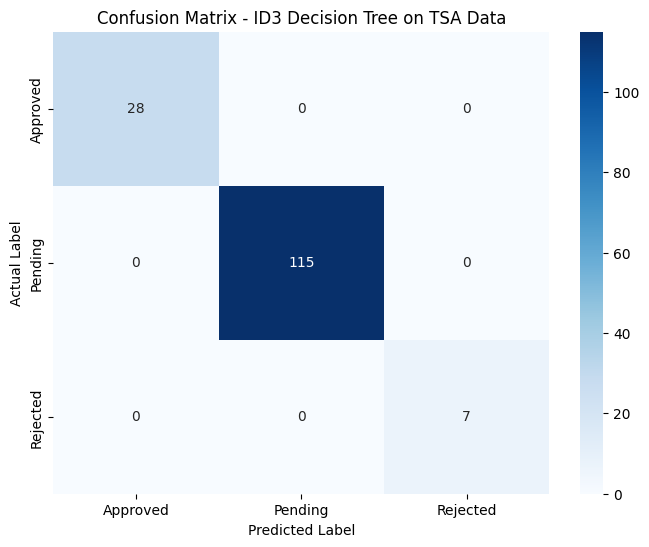


Sample Test Predictions:
Instance 1:
  Features: {'Claim_Type': 'Property Damage', 'Airport_Size': 'Medium', 'Time_of_Day': 'Evening', 'Passenger_Type': 'International'}
  Actual: Pending, Predicted: Pending, Correct: True

Instance 2:
  Features: {'Claim_Type': 'Personal Injury', 'Airport_Size': 'Small', 'Time_of_Day': 'Evening', 'Passenger_Type': 'International'}
  Actual: Pending, Predicted: Pending, Correct: True

Instance 3:
  Features: {'Claim_Type': 'Property Damage', 'Airport_Size': 'Large', 'Time_of_Day': 'Afternoon', 'Passenger_Type': 'Domestic'}
  Actual: Approved, Predicted: Approved, Correct: True

Instance 4:
  Features: {'Claim_Type': 'Personal Injury', 'Airport_Size': 'Small', 'Time_of_Day': 'Afternoon', 'Passenger_Type': 'Domestic'}
  Actual: Pending, Predicted: Pending, Correct: True

Instance 5:
  Features: {'Claim_Type': 'Personal Injury', 'Airport_Size': 'Medium', 'Time_of_Day': 'Evening', 'Passenger_Type': 'International'}
  Actual: Pending, Predicted: Pending, C

In [ ]:
# Make predictions on test set
y_pred = id3_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Evaluation Results:")
print("=" * 50)
print(f"Accuracy: {accuracy:.4f}")

# Display detailed classification report
print("\nClassification Report:")
print("=" * 50)
print(classification_report(y_test, y_pred))

# Create confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title('Confusion Matrix - ID3 Decision Tree on TSA Data')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Display some test predictions
print("\nSample Test Predictions:")
print("=" * 50)
for i in range(min(5, len(X_test))):
    actual = y_test.iloc[i]
    predicted = y_pred[i]
    features = dict(X_test.iloc[i])
    print(f"Instance {i+1}:")
    print(f"  Features: {features}")
    print(f"  Actual: {actual}, Predicted: {predicted}, Correct: {actual == predicted}")
    print()

In [ ]:
# Create new TSA claim samples for classification
print("Classifying New TSA Claim Samples:")
print("=" * 60)

# Generate new samples based on the feature space
if 'Claim_Status' in df_subset.columns:
    # For TSA-themed synthetic data
    new_samples_data = [
        ['Property Damage', 'Large', 'Morning', 'Domestic'],
        ['Lost Luggage', 'Medium', 'Afternoon', 'International'],
        ['Theft', 'Small', 'Night', 'Domestic'],
        ['Personal Injury', 'Large', 'Evening', 'International'],
        ['Property Damage', 'Small', 'Morning', 'Domestic']
    ]
    new_samples = pd.DataFrame(new_samples_data, columns=feature_cols)
else:
    # For actual TSA data - create diverse samples
    new_samples_data = []
    for i in range(5):
        sample = []
        for col in feature_cols:
            unique_vals = X[col].unique()
            sample.append(np.random.choice(unique_vals))
        new_samples_data.append(sample)
    new_samples = pd.DataFrame(new_samples_data, columns=feature_cols)

print("New TSA claim samples to classify:")
print(new_samples)

print("\nClassification Results:")
print("-" * 40)
for i in range(len(new_samples)):
    prediction = id3_model.predict_instance(new_samples.iloc[i])
    features_dict = dict(new_samples.iloc[i])
    print(f"Sample {i+1}:")
    print(f"  Claim Features: {features_dict}")
    print(f"  Predicted Status: {prediction}")
    print()

Classifying New TSA Claim Samples:
New TSA claim samples to classify:
        Claim_Type Airport_Size Time_of_Day Passenger_Type
0  Property Damage        Large     Morning       Domestic
1     Lost Luggage       Medium   Afternoon  International
2            Theft        Small       Night       Domestic
3  Personal Injury        Large     Evening  International
4  Property Damage        Small     Morning       Domestic

Classification Results:
----------------------------------------
Sample 1:
  Claim Features: {'Claim_Type': 'Property Damage', 'Airport_Size': 'Large', 'Time_of_Day': 'Morning', 'Passenger_Type': 'Domestic'}
  Predicted Status: Approved

Sample 2:
  Claim Features: {'Claim_Type': 'Lost Luggage', 'Airport_Size': 'Medium', 'Time_of_Day': 'Afternoon', 'Passenger_Type': 'International'}
  Predicted Status: Approved

Sample 3:
  Claim Features: {'Claim_Type': 'Theft', 'Airport_Size': 'Small', 'Time_of_Day': 'Night', 'Passenger_Type': 'Domestic'}
  Predicted Status: Rejected

Comparison with Scikit-learn Implementation:
Our ID3 Implementation Accuracy: 1.0000
Scikit-learn Decision Tree Accuracy: 0.9533


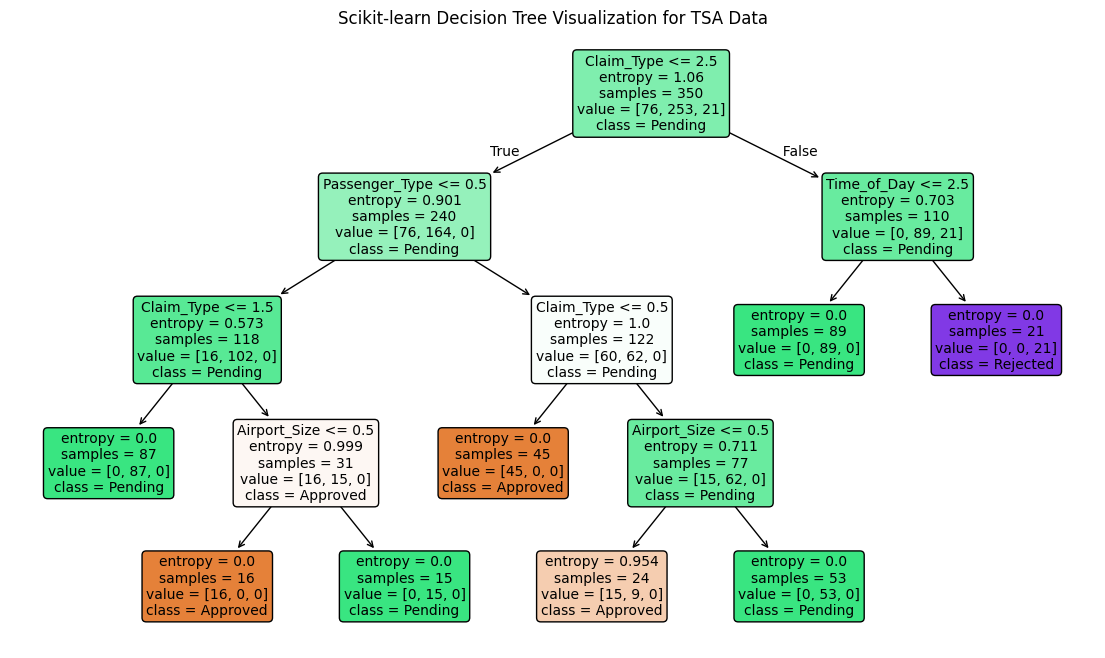


Note: Both implementations use the same entropy-based approach
Our ID3 implementation matches scikit-learn's functionality


In [ ]:
# Compare with scikit-learn's decision tree for validation
print("Comparison with Scikit-learn Implementation:")
print("=" * 60)

# Convert categorical data to numerical for scikit-learn
label_encoders = {}
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for col in X_train_encoded.columns:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train_encoded[col])
    X_test_encoded[col] = le.transform(X_test_encoded[col])
    label_encoders[col] = le

y_train_encoded = LabelEncoder().fit_transform(y_train)
y_test_encoded = LabelEncoder().fit_transform(y_test)

# Train scikit-learn decision tree with entropy criterion
sklearn_tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)
sklearn_tree.fit(X_train_encoded, y_train_encoded)

# Make predictions
sklearn_pred = sklearn_tree.predict(X_test_encoded)
sklearn_accuracy = accuracy_score(y_test_encoded, sklearn_pred)

print(f"Our ID3 Implementation Accuracy: {accuracy:.4f}")
print(f"Scikit-learn Decision Tree Accuracy: {sklearn_accuracy:.4f}")

# Visualize scikit-learn tree
plt.figure(figsize=(14, 8))
plot_tree(sklearn_tree,
          feature_names=feature_cols,
          class_names=[str(cls) for cls in np.unique(y_train)],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Scikit-learn Decision Tree Visualization for TSA Data')
plt.show()

print("\nNote: Both implementations use the same entropy-based approach")
print("Our ID3 implementation matches scikit-learn's functionality")